# Calculate Time Averages from Time Series Data

Author: [Tom Vo](https://github.com/tomvothecoder/) & [Jiwoo Lee](https://github.com/lee1043/)

Updated: 04/01/24 [xcdat v0.6.1]

Related APIs:

- [xarray.Dataset.temporal.average()](../generated/xarray.Dataset.temporal.average.rst)
- [xarray.Dataset.temporal.group_average()](../generated/xarray.Dataset.temporal.group_average.rst)


## Overview

Suppose we have netCDF4 files for air temperature data (`tas`) with monthly, daily, and 3hr frequencies.

We want to calculate averages using these files with the time dimension removed (a single time snapshot), and averages by time group (yearly, seasonal, and daily).

The data used in this example can be found through the [Earth System Grid Federation (ESGF) search portal](https://aims2.llnl.gov/metagrid/search).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook_0.7.0 -c conda-forge xcdat=0.7.0 xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter
```

Then install the kernel from the `xcdat_notebook_0.7.0` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook_0.7.0`):

```bash
python -m ipykernel install --user --name xcdat_notebook_0.7.0 --display-name xcdat_notebook_0.7.0
```

Then to select the kernel `xcdat_notebook_0.7.0` in Jupyter to use this kernel.


In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import xcdat


## 1. Calculate averages with the time dimension removed (single snapshot)

Related API: [xarray.Dataset.temporal.average()](../generated/xarray.Dataset.temporal.average.rst)

Helpful knowledge:

- The frequency for the time interval is inferred before calculating weights.

  - The frequency is inferred by calculating the minimum delta between time coordinates and using the conditional logic below. This frequency is used to calculate weights.

- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data are excluded when averages are calculated. This is the same as giving them a weight of 0.


### Open the `Dataset`

In this example, we will be calculating the time weighted averages with the time dimension removed (single snapshot) for monthly `tas` data.

We are using xarray's OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

_More information on the xarray's OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap)._


In [2]:
filepath = "https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/tas/gn/v20200605/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc"
ds = xcdat.open_dataset(filepath)

# Unit adjust (-273.15, K to C)
ds["tas"] = ds.tas - 273.15

ds

<xarray.Dataset> Size: 221MB
Dimensions:    (time: 1980, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B 2.0
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 32kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 220MB -27.19 -27.19 ... -25.29 -25.29
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
ds_avg = ds.temporal.average("tas", weighted=True)

In [4]:
ds_avg.tas

<xarray.DataArray 'tas' (lat: 145, lon: 192)> Size: 223kB
array([[-48.01481628, -48.01481628, -48.01481628, ..., -48.01481628,
        -48.01481628, -48.01481628],
       [-44.94085363, -44.97948214, -45.01815398, ..., -44.82408252,
        -44.86273067, -44.9009281 ],
       [-44.11875274, -44.23060624, -44.33960158, ..., -43.76766492,
        -43.88593717, -44.00303006],
       ...,
       [-18.21076615, -18.17513373, -18.13957458, ..., -18.32720478,
        -18.28428828, -18.2486193 ],
       [-18.50778243, -18.49301854, -18.47902819, ..., -18.55410851,
        -18.5406963 , -18.52413098],
       [-19.07366375, -19.07366375, -19.07366375, ..., -19.07366375,
        -19.07366375, -19.07366375]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
Attributes:
    operation:  temporal_avg
    mode:       average
    freq:       month
    weighted:   True

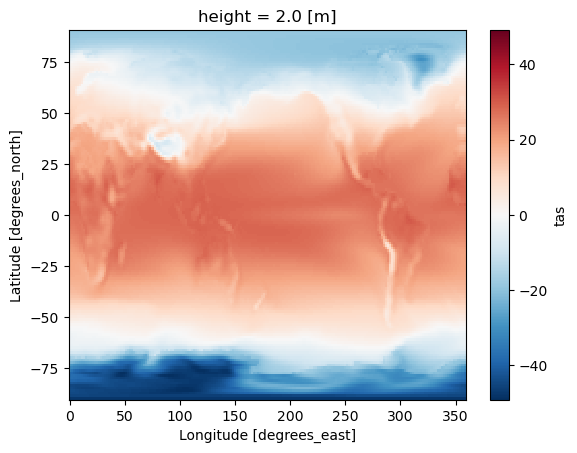

In [5]:
ds_avg.tas.plot(label="weighted")

## 2. Calculate grouped averages

Related API: [xarray.Dataset.temporal.group_average()](../generated/xarray.Dataset.temporal.group_average.rst)

Helpful knowledge:

- Each specified frequency has predefined groups for grouping time coordinates.

  - The table below maps type of averages with its API frequency and grouping convention.

    | Type of Averages | API Frequency                                                            | Group By               |
    | ---------------- | ------------------------------------------------------------------------ | ---------------------- |
    | Yearly           | `freq=“year”`                                                            | year                   |
    | Monthly          | `freq=“month”`                                                           | year, month            |
    | Seasonal         | `freq=“season”`                                                          | year, season           |
    | Custom seasonal  | `freq="season"` and </br> `season_config={"custom_seasons": <2D ARRAY>}` | year, season           |
    | Daily            | `freq=“day”`                                                             | year, month, day       |
    | Hourly           | `freq=“hour”`                                                            | year, month, day, hour |

  - The grouping conventions are based on [CDAT/cdutil](https://github.com/CDAT/cdutil/blob/b823b69db46bb76536db7d435e72075fc3975c65/cdutil/times.py#L1620-L1640), except for daily and hourly means which aren't implemented in CDAT/cdutil.

- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data are excluded when averages are calculated. This is the same as giving them a weight of 0.


### Open the `Dataset`

In this example, we will be calculating the weighted grouped time averages for `tas` data.

We are using xarray's OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

_More information on the xarray's OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap)._


In [6]:
filepath = "https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/tas/gn/v20200605/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc"
ds = xcdat.open_dataset(filepath)

# Unit adjust (-273.15, K to C)
ds["tas"] = ds.tas - 273.15

ds

<xarray.Dataset> Size: 221MB
Dimensions:    (time: 1980, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B 2.0
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 32kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 220MB -27.19 -27.19 ... -25.29 -25.29
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

### Yearly Averages

**Group time coordinates by year**


In [7]:
ds_yearly = ds.temporal.group_average("tas", freq="year", weighted=True)

In [8]:
ds_yearly.tas

<xarray.DataArray 'tas' (time: 165, lat: 145, lon: 192)> Size: 37MB
array([[[-48.75573349, -48.75573349, -48.75573349, ..., -48.75573349,
         -48.75573349, -48.75573349],
        [-45.65206528, -45.69302368, -45.73506165, ..., -45.52127838,
         -45.56386566, -45.60668945],
        [-44.77523422, -44.90583801, -45.03297043, ..., -44.37118149,
         -44.50630951, -44.64050293],
        ...,
        [-20.50597572, -20.48132133, -20.45456505, ..., -20.58895874,
         -20.55752182, -20.53087234],
        [-20.79759216, -20.78425217, -20.77545547, ..., -20.83267975,
         -20.82335663, -20.80768394],
        [-21.20114899, -21.20114899, -21.20114899, ..., -21.20114899,
         -21.20114899, -21.20114899]],

       [[-48.95254898, -48.95254898, -48.95254898, ..., -48.95254898,
         -48.95254898, -48.95254898],
        [-45.83190918, -45.8649025 , -45.89875031, ..., -45.7321701 ,
         -45.76544189, -45.79859543],
        [-44.93536758, -45.03795624, -45.13800812, ..., -44.61143112,
         -44.71986008, -44.82937241],
...
        [-14.91627121, -14.89926147, -14.88381004, ..., -14.99542999,
         -14.96513653, -14.93853188],
        [-15.40592194, -15.39668083, -15.38595486, ..., -15.43246269,
         -15.42605591, -15.41356754],
        [-15.94499969, -15.94499969, -15.94499969, ..., -15.94499969,
         -15.94499969, -15.94499969]],

       [[-47.59732056, -47.59732056, -47.59732056, ..., -47.59732056,
         -47.59732056, -47.59732056],
        [-44.72136688, -44.76342773, -44.80350494, ..., -44.59239197,
         -44.63444519, -44.67822647],
        [-43.85031891, -43.96956253, -44.08713913, ..., -43.47090149,
         -43.59676361, -43.72407913],
        ...,
        [-14.52023029, -14.47407913, -14.43230724, ..., -14.67551422,
         -14.62093163, -14.56736755],
        [-14.91123581, -14.89230919, -14.86901569, ..., -14.9820118 ,
         -14.96266842, -14.93872261],
        [-15.6184063 , -15.6184063 , -15.6184063 , ..., -15.6184063 ,
         -15.6184063 , -15.6184063 ]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 1kB 1850-01-01 00:00:00 ... 2014-01-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       group_average
    freq:       year
    weighted:   True

![tas yearly averages](../examples/temporal-average-yearly.gif)

_This GIF was created using [xmovie](https://github.com/jbusecke/xmovie)._

Sample `xmovie` code:

```python
import xmovie
mov = xmovie.Movie(ds_yearly_avg.tas)
mov.save("temporal-average-yearly.gif")
```


### Seasonal Averages

**Group time coordinates by year and season**


In [9]:
ds_season = ds.temporal.group_average("tas", freq="season", weighted=True)

In [10]:
ds_season.tas

<xarray.DataArray 'tas' (time: 661, lat: 145, lon: 192)> Size: 147MB
array([[[-32.70588303, -32.70588303, -32.70588303, ..., -32.70588303,
         -32.70588303, -32.70588303],
        [-30.99376678, -31.03758621, -31.08932686, ..., -30.84562302,
         -30.89412689, -30.94400978],
        [-30.0251503 , -30.14543724, -30.26419067, ..., -29.66037178,
         -29.78108025, -29.90287781],
        ...,
        [-37.72314072, -37.68549347, -37.65416718, ..., -37.82619858,
         -37.79034424, -37.75682831],
        [-38.27464676, -38.26372528, -38.25014496, ..., -38.29218292,
         -38.29063797, -38.28456116],
        [-38.74358749, -38.74358749, -38.74358749, ..., -38.74358749,
         -38.74358749, -38.74358749]],

       [[-54.29086304, -54.29086304, -54.29086304, ..., -54.29086304,
         -54.29086304, -54.29086304],
        [-51.11771393, -51.17523575, -51.23055267, ..., -50.93516541,
         -50.99657059, -51.05614471],
        [-50.31804657, -50.48666382, -50.64956665, ..., -49.79003143,
         -49.97007751, -50.14521027],
...
        [-12.34277439, -12.2246685 , -12.10663223, ..., -12.74492168,
         -12.60908794, -12.47839165],
        [-13.12640381, -13.0661087 , -13.00387573, ..., -13.306077  ,
         -13.25871468, -13.19972038],
        [-14.28846931, -14.28846931, -14.28846931, ..., -14.28846931,
         -14.28846931, -14.28846931]],

       [[-28.99049377, -28.99049377, -28.99049377, ..., -28.99049377,
         -28.99049377, -28.99049377],
        [-28.19291687, -28.22457886, -28.26130676, ..., -28.09593201,
         -28.12599182, -28.15802002],
        [-27.60740662, -27.7056427 , -27.80511475, ..., -27.31161499,
         -27.41082764, -27.50836182],
        ...,
        [-24.25627136, -24.14059448, -24.03753662, ..., -24.61853027,
         -24.48849487, -24.36643982],
        [-24.62901306, -24.61338806, -24.54986572, ..., -24.75204468,
         -24.72160339, -24.66641235],
        [-25.28923035, -25.28923035, -25.28923035, ..., -25.28923035,
         -25.28923035, -25.28923035]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 5kB 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    operation:            temporal_avg
    mode:                 group_average
    freq:                 season
    weighted:             True
    dec_mode:             DJF
    drop_incomplete_djf:  False

**Notice that the season of each time coordinate is represented by its middle month.**

- "DJF" is represented by month 1 ("J"/January)
- "MAM" is represented by month 4 ("A"/April)
- "JJA" is represented by month 7 ("J"/July)
- "SON" is represented by month 10 ("O"/October).

This is implementation design was used because `datetime` objects do not distinguish seasons, so the middle month is used instead.


In [11]:
ds_season.time

<xarray.DataArray 'time' (time: 661)> Size: 5kB
array([cftime.DatetimeProlepticGregorian(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2014, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2014, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2015, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 8B 2.0
  * time     (time) object 5kB 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    1

### Visualize averages derived from monthly data on a specific point


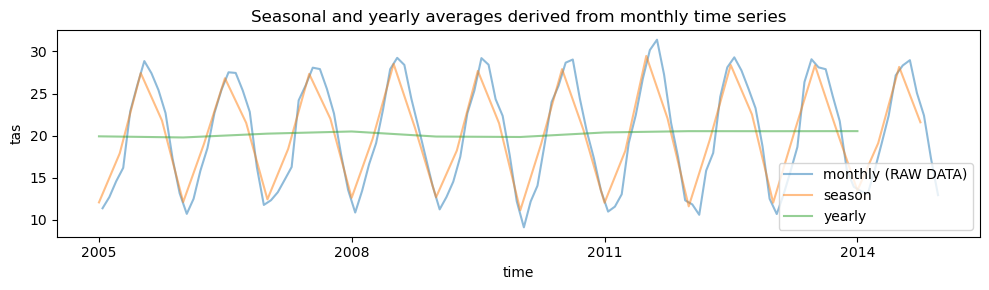

In [12]:
# plot time series of temporal averages for a specific grid point: seasonal and yearly averages derived from monthly time series
lat_point = 30
lon_point = 30

start_year = "2005-01-01"
end_year = "2014-12-31"

plt.figure(figsize=(10, 3))
ax = plt.subplot()

ds.tas.sel(lat=lat_point, lon=lon_point, time=slice(start_year, end_year)).plot(
    ax=ax, label="monthly (RAW DATA)", alpha=0.5
)
ds_season.tas.sel(lat=lat_point, lon=lon_point, time=slice(start_year, end_year)).plot(
    ax=ax, label="season", alpha=0.5
)
ds_yearly.tas.sel(lat=lat_point, lon=lon_point, time=slice(start_year, end_year)).plot(
    ax=ax, label="yearly", alpha=0.5
)

plt.title("Seasonal and yearly averages derived from monthly time series")

plt.legend()
plt.tight_layout()

### Monthly Averages

**Group time coordinates by year and month**

For this example, we will be loading a subset of daily time series data for `tas` using OPeNDAP.

---

**NOTE:**

For OPeNDAP servers, the default file size request limit is 500MB in the TDS server configuration. Opening up a dataset over OPeNDAP also introduces an overhead compared to direct file access.

**The workaround is to use Dask to request the data in manageable chunks, which overcomes file size limitations and can improve performance.**

We have a few ways to chunk our request:

1. Specify `chunks` with `"auto"` to let Dask determine the chunksize.
2. Specify a specify the file size to chunk on (e.g., `"100MB"`) or number of chunks as an integer (`100` for 100 chunks).

Visit this page to learn more about chunking and performance: https://docs.xarray.dev/en/stable/user-guide/dask.html#chunking-and-performance

---


In [13]:
# The size of this file is approximately 1.45 GB, so we will be chunking our
# request using Dask to avoid hitting the OPeNDAP file size request limit for
# this ESGF node.
ds2 = xcdat.open_dataset(
    "https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/3hr/tas/gn/v20200605/tas_3hr_ACCESS-ESM1-5_historical_r10i1p1f1_gn_201001010300-201501010000.nc",
    chunks={"time": "auto"},
    add_bounds=["T"],
)

# Unit adjust (-273.15, K to C)
ds2["tas"] = ds2.tas - 273.15

ds2

<xarray.Dataset> Size: 2GB
Dimensions:    (lat: 145, bnds: 2, lon: 192, time: 14608)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B ...
  * time       (time) object 117kB 2010-01-01 03:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 2GB dask.array<chunksize=(1205, 145, 192), meta=np.ndarray>
    time_bnds  (time, bnds) object 234kB 2010-01-01 03:00:00 ... 2015-01-01 0...
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:54:56Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/b79e6a05-c482-46cf-b3b8-83b...
    DODS_EXTRA.Unlimited_Dimension:  time

In [14]:
ds2_monthly_avg = ds2.temporal.group_average("tas", freq="month", weighted=True)

In [15]:
ds2_monthly_avg.tas

<xarray.DataArray 'tas' (time: 61, lat: 145, lon: 192)> Size: 14MB
dask.array<truediv, shape=(61, 145, 192), dtype=float64, chunksize=(1, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B ...
  * time     (time) object 488B 2010-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       group_average
    freq:       month
    weighted:   True

### Daily Averages

**Group time coordinates by year, month, and day**

For this example, we will be opening a subset of 3hr time series data for `tas` using OPeNDAP.


In [16]:
# The size of this file is approximately 1.17 GB, so we will be chunking our
# request using Dask to avoid hitting the OPeNDAP file size request limit for
# this ESGF node.
ds3 = xcdat.open_dataset(
    "https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/3hr/tas/gn/v20200605/tas_3hr_ACCESS-ESM1-5_historical_r10i1p1f1_gn_201001010300-201501010000.nc",
    chunks={"time": "auto"},
    add_bounds=["T"],
)

# Unit adjust (-273.15, K to C)
ds3["tas"] = ds3.tas - 273.15

In [17]:
ds3.tas

<xarray.DataArray 'tas' (time: 14608, lat: 145, lon: 192)> Size: 2GB
dask.array<sub, shape=(14608, 145, 192), dtype=float32, chunksize=(1205, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B ...
  * time     (time) object 117kB 2010-01-01 03:00:00 ... 2015-01-01 00:00:00

In [18]:
ds3_day_avg = ds3.temporal.group_average("tas", freq="day", weighted=True)

In [19]:
ds3_day_avg.tas

<xarray.DataArray 'tas' (time: 1827, lat: 145, lon: 192)> Size: 407MB
dask.array<truediv, shape=(1827, 145, 192), dtype=float64, chunksize=(1, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B ...
  * time     (time) object 15kB 2010-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       group_average
    freq:       day
    weighted:   True

### Visualize averages derived from 3-hourly data on a specific point


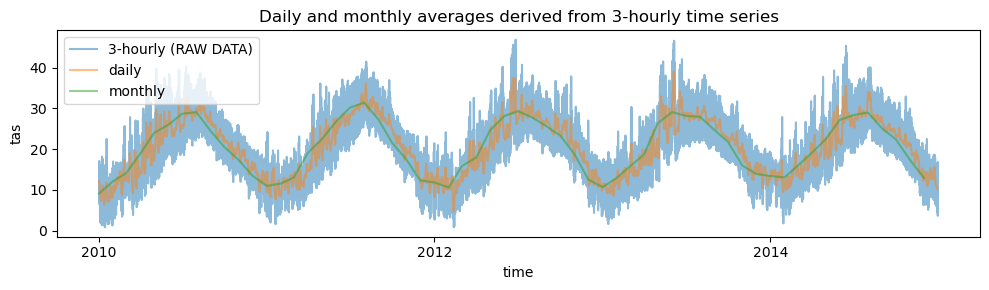

In [20]:
# plot time series of temporal averages for a specific grid point: daily and monthly averages derived from 3-hourly time series
lat_point = 30
lon_point = 30

start_year = "2010-01-01"
end_year = "2014-12-31"

plt.figure(figsize=(10, 3))
ax = plt.subplot()

ds2.tas.sel(lat=lat_point, lon=lon_point, time=slice(start_year, end_year)).plot(
    ax=ax, label="3-hourly (RAW DATA)", alpha=0.5
)
ds3_day_avg.tas.sel(
    lat=lat_point, lon=lon_point, time=slice(start_year, end_year)
).plot(ax=ax, label="daily", alpha=0.5)
ds2_monthly_avg.tas.sel(
    lat=lat_point, lon=lon_point, time=slice(start_year, end_year)
).plot(ax=ax, label="monthly", alpha=0.5)

plt.title("Daily and monthly averages derived from 3-hourly time series")
plt.legend()
plt.tight_layout()